In [26]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from copy import deepcopy
bary_scenarios = ['mb2', 'illustris', 'eagle', 'HzAGN', 'TNG100', 'cowls_AGN', 'cowls_AGN_T8p5',
                      'cowls_AGN_T8p7', 'BAHAMAS', 'BAHAMAS_T7p6', 'BAHAMAS_T8p0']

def readCov(cov_fn):
    lines = np.genfromtxt(cov_fn)
    nd = np.max(lines[:,0]).astype(int)+1
    cov = np.zeros([nd, nd])
    for line in lines:
        i,j = int(line[0]), int(line[1])
        cg, cng = line[8], line[9]
        cov[i,j] = cg+cng
        cov[j,i] = cg+cng
    return cov

def generate_baryonic_PCA(cov_fn, data_vector_fmt, PCs_fn, write=False, remove=['illustris'], nPCs=6):
    # we exclude "illustris"
    _bary_scenarios = deepcopy(bary_scenarios)
    for sce in remove:
        _bary_scenarios.remove(sce)
    
    cov = readCov(cov_fn)
    cov_L_cholesky = LA.cholesky(cov)
    inv_cov_L_cholesky = LA.inv(cov_L_cholesky)
    
    modelv_dm = np.genfromtxt(data_vector_fmt+"_dmo")[:,1]
    ndata_reduced = len(modelv_dm)
    nbaryons_scenario = len(_bary_scenarios)
    baryon_diff = np.zeros(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        modelv_baryon = np.genfromtxt(data_vector_fmt+"_%s"%(_bary_scenarios[i]))[:,1]
        baryon_diff[:,i] = (modelv_baryon-modelv_dm)

    baryon_weighted_diff = np.dot(inv_cov_L_cholesky, baryon_diff)

    U, Sdig, VT = LA.svd(baryon_weighted_diff, full_matrices=True)
    
    # MAKE SURE WHATEVER VERSION OF NP HAVE U IN THE RIGHT ORDER
    if(np.all(np.diff(Sdig) <= 0) != True):
        raise LoggedError(self.log, "LOGICAL ERROR WITH NUMPY FUNCTION GEN PCA")

    PCs = np.empty(shape=(ndata_reduced, nbaryons_scenario))

    for i in range(nbaryons_scenario):
        PCs[:,i] = U[:,i]

    PCs = np.dot(cov_L_cholesky, PCs)

    if write:
        np.savetxt(PCs_fn, PCs[:,:nPCs], fmt='%le')
    return Sdig
        
def get_PC_amplitude(cov_fn, PCs_fn, data_vector_fmt, bary_scenario):
    ''' retrieve the Qs of a specific baryon scenario
    '''
    cov = readCov(cov_fn)
    cov_L_cholesky = LA.cholesky(cov)
    inv_cov_L_cholesky = LA.inv(cov_L_cholesky)
    
    modelv_dm = np.genfromtxt(data_vector_fmt+"_dmo")[:,1]
    ndata_reduced = len(modelv_dm)
    modelv_baryon = np.genfromtxt(data_vector_fmt+"_%s"%(bary_scenario))[:,1]
    baryon_diff = modelv_baryon - modelv_dm
    baryon_diff_weighted = np.dot(inv_cov_L_cholesky, baryon_diff)
    
    baryon_PCs = np.genfromtxt(PCs_fn)
    baryon_PCs_deweight = np.dot(inv_cov_L_cholesky, baryon_PCs)
    
    Qs = np.dot(baryon_PCs_deweight.T, baryon_diff_weighted)
    
    return Qs

In [31]:
# dvfmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15"
# covfmt="/xdisk/timeifler/jiachuanxu/DESI2KL/cov/DESI2_KL_v2_%d%d_ssss_cov_Ncl15_Ntomo4"
# PCs_fmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/DESI2_KL_%d%d_shear_shear_Ntomo4_Ncl15_%dsim.pca"

### Wide
dvfmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/Roman_WL_103_shear_shear_Ntomo10_Ncl15_Haley_dndz"
covfmt="/xdisk/timeifler/jiachuanxu/RomanPIT/cov/Roman_Wide_ssss_cov_Ncl15_Ntomo10_Haley_dndz"
PCs_fmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/Roman_Wide_shear_shear_Ntomo10_Ncl15_%dsim.pca"

### Medium
# dvfmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/Roman_WL_403_shear_shear_Ntomo10_Ncl15_Haley_dndz"
# covfmt="/xdisk/timeifler/jiachuanxu/RomanPIT/cov/Roman_Medium_ssss_cov_Ncl15_Ntomo10_Haley_dndz"
# PCs_fmt="/home/u17/jiachuanxu/CosmoLike/KL_WFIRST/datav/Roman_Medium_shear_shear_Ntomo10_Ncl15_%dsim.pca"

In [32]:
# for i in range(6): # target selection
#     for j in range(6): # shape noise (different weights)
        
# use 9 simulations to generate PCs
# var_frac = generate_baryonic_PCA(covfmt%(i,j), dvfmt%(i,0), PCs_fmt%(i,j,9), write=True, 
#                                  remove=['illustris', 'eagle'])
var_frac = generate_baryonic_PCA(covfmt, dvfmt, PCs_fmt%(9), write=True, 
                                 remove=['illustris', 'eagle'])
var_frac = var_frac / np.sum(var_frac) * 100
# sanity test by the fraction of variance of the first three PCs
print(f'Fraction of variance: %.2f / %.2f / %2f percents'%(var_frac[0], var_frac[1], var_frac[2]))

# use 10 simulations to generate PCs
# var_frac = generate_baryonic_PCA(covfmt%(i,j), dvfmt%(i,0), PCs_fmt%(i,j,10), write=True, 
#                                  remove=['illustris'])
var_frac = generate_baryonic_PCA(covfmt, dvfmt, PCs_fmt%(10), write=True, 
                                 remove=['illustris'])
var_frac = var_frac / np.sum(var_frac) * 100
# sanity test by the fraction of variance of the first three PCs
print(f'Fraction of variance: %.2f / %.2f / %2f percents'%(var_frac[0], var_frac[1], var_frac[2]))

Fraction of variance: 87.12 / 6.26 / 1.972996 percents
Fraction of variance: 86.07 / 6.59 / 2.219299 percents


Get the Qs of each scenarios

In [10]:
Qs_range_9sim = []
# for i in range(6): # target selection
#     for j in range(6): # shape noise (different weights)
Qs_dict = {}
for sce in bary_scenarios:
    #Qs = get_PC_amplitude(covfmt%(i,j), PCs_fmt%(i,j,9), dvfmt%(i,0), sce)
    Qs = get_PC_amplitude(covfmt, PCs_fmt%(9), dvfmt, sce)
    Qs_dict[sce] = Qs
Qs_range_9sim.append(Qs_dict)

In [11]:
Qs_range_10sim = []
# for i in range(6): # target selection
#     for j in range(6): # shape noise (different weights)
Qs_dict = {}
for sce in bary_scenarios:
#     Qs = get_PC_amplitude(covfmt%(i,j), PCs_fmt%(i,j,10), dvfmt%(i,0), sce)
    Qs = get_PC_amplitude(covfmt, PCs_fmt%(10), dvfmt, sce)
    Qs_dict[sce] = Qs
Qs_range_10sim.append(Qs_dict)

Q1 range (-117.82637709758802, 0.9321415047437477)
Q2 range (-8.40149220120872, 7.223296091189488)
Q3 range (-2.0925715375207266, 2.333085197052412)


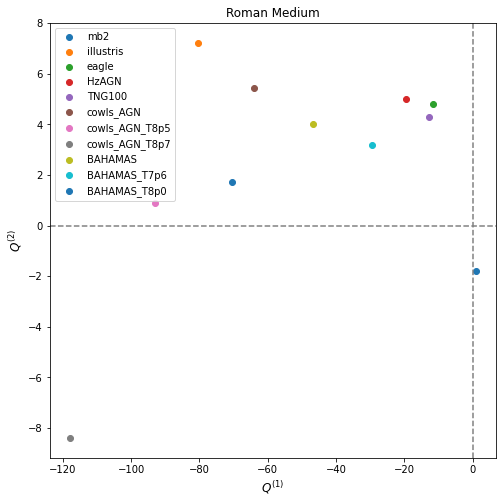

In [12]:
### Medium Tier
### Q1: [-120, 0]
### Q2: [-8, 8]
fig, ax = plt.subplots(1,1, figsize=[8,8])
Q1s, Q2s, Q3s = [], [], []
for k,v in Qs_range_9sim[0].items():
    ax.scatter(v[0], v[1], label=k)
    Q1s.append(v[0])
    Q2s.append(v[1])
    Q3s.append(v[2])
print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
ax.set_title("Roman Medium")
ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
ax.axvline(0, ls='--', color='grey')
ax.axhline(0, ls='--', color='grey')
ax.legend()

plt.show()

Q1 range (-117.81350452272012, 0.9357899497031537)
Q2 range (-8.508633040964332, 6.84291456319496)
Q3 range (-2.8023861859106916, 2.1875648719937173)


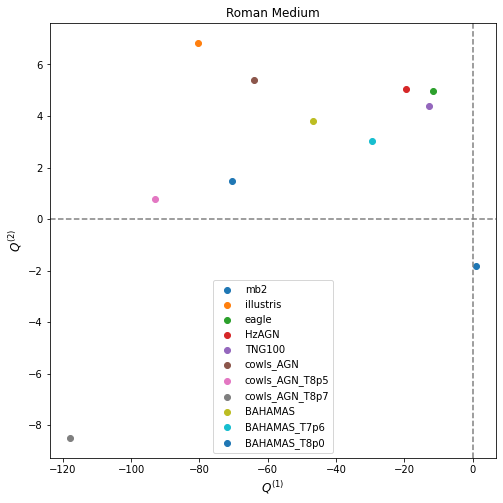

In [13]:
fig, ax = plt.subplots(1,1, figsize=[8,8])
Q1s, Q2s, Q3s = [], [], []
for k,v in Qs_range_10sim[0].items():
    ax.scatter(v[0], v[1], label=k)
    Q1s.append(v[0])
    Q2s.append(v[1])
    Q3s.append(v[2])
print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
ax.set_title("Roman Medium")
ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
ax.axvline(0, ls='--', color='grey')
ax.axhline(0, ls='--', color='grey')
ax.legend()

plt.show()

In [15]:
### Wide Tier
Qs_range_9sim = []
# for i in range(6): # target selection
#     for j in range(6): # shape noise (different weights)
Qs_dict = {}
for sce in bary_scenarios:
    #Qs = get_PC_amplitude(covfmt%(i,j), PCs_fmt%(i,j,9), dvfmt%(i,0), sce)
    Qs = get_PC_amplitude(covfmt, PCs_fmt%(9), dvfmt, sce)
    Qs_dict[sce] = Qs
Qs_range_9sim.append(Qs_dict)

Qs_range_10sim = []
# for i in range(6): # target selection
#     for j in range(6): # shape noise (different weights)
Qs_dict = {}
for sce in bary_scenarios:
#     Qs = get_PC_amplitude(covfmt%(i,j), PCs_fmt%(i,j,10), dvfmt%(i,0), sce)
    Qs = get_PC_amplitude(covfmt, PCs_fmt%(10), dvfmt, sce)
    Qs_dict[sce] = Qs
Qs_range_10sim.append(Qs_dict)

Q1 range (-104.66223197958881, 0.965442332752767)
Q2 range (-7.529444294786679, 5.624828192135739)
Q3 range (-1.9744693105781042, 2.1200805509691314)


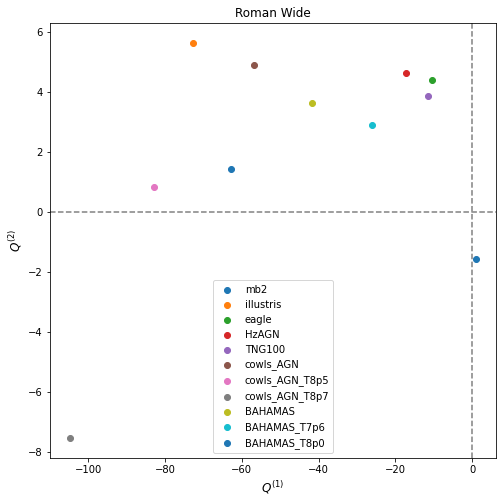

In [17]:
### Wide Tier
### Q1: [-120, 0]
### Q2: [-8, 6]
fig, ax = plt.subplots(1,1, figsize=[8,8])
Q1s, Q2s, Q3s = [], [], []
for k,v in Qs_range_9sim[0].items():
    ax.scatter(v[0], v[1], label=k)
    Q1s.append(v[0])
    Q2s.append(v[1])
    Q3s.append(v[2])
print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
ax.set_title("Roman Wide")
ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
ax.axvline(0, ls='--', color='grey')
ax.axhline(0, ls='--', color='grey')
ax.legend()

plt.show()

Q1 range (-104.65037111741486, 0.9683084029537558)
Q2 range (-7.630093611126818, 5.29560654424067)
Q3 range (-2.497679156665469, 1.9954407838539994)


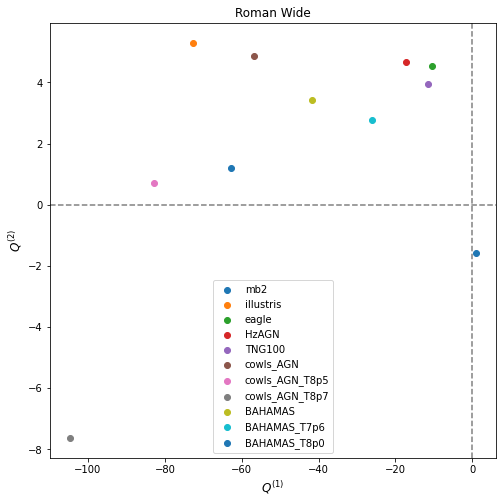

In [18]:
fig, ax = plt.subplots(1,1, figsize=[8,8])
Q1s, Q2s, Q3s = [], [], []
for k,v in Qs_range_10sim[0].items():
    ax.scatter(v[0], v[1], label=k)
    Q1s.append(v[0])
    Q2s.append(v[1])
    Q3s.append(v[2])
print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
ax.set_title("Roman Wide")
ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
ax.axvline(0, ls='--', color='grey')
ax.axhline(0, ls='--', color='grey')
ax.legend()

plt.show()

In [19]:
Q1s

[0.9683084029537558,
 -72.56729776936774,
 -10.447656402676154,
 -17.24569797818542,
 -11.581297781734765,
 -56.842853954470975,
 -82.72130599424294,
 -104.65037111741486,
 -41.64806053188279,
 -26.10290957598337,
 -62.66858332073751]

Target selection 0; Shape noise 0
Q1 range (-44.354295295768445, 2.50966135796539)
Q2 range (-8.454658370554423, 6.316401994768059)
Q3 range (-5.275150671836004, 2.8709020877830005)
Target selection 0; Shape noise 1
Q1 range (-24.926094428049048, 0.9560226046790885)
Q2 range (-3.473124561318693, 2.5362588826486068)
Q3 range (-1.065935531893415, 2.1773982984081166)
Target selection 0; Shape noise 2
Q1 range (-15.763056818151222, 0.46159022733565175)
Q2 range (-1.8412219370384582, 1.3321769552166396)
Q3 range (-0.532729889065435, 1.1819383594968311)
Target selection 0; Shape noise 3
Q1 range (-7.427763753798025, 0.1531398801422639)
Q2 range (-0.7763609269149812, 0.551914125281295)
Q3 range (-0.20741460691467029, 0.49618990051569245)
Target selection 0; Shape noise 4
Q1 range (-2.298403613232878, 0.025769826667477264)
Q2 range (-0.22575156110255143, 0.15543951883830653)
Q3 range (-0.05478509808568775, 0.13548595655001994)
Target selection 0; Shape noise 5
Q1 range (-1.0743230826121408, 0.

/tmp/ipykernel_30963/517843434.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=[8,8])


Target selection 3; Shape noise 3
Q1 range (-0.4901903620223465, 0.011160418795232262)
Q2 range (-0.050424622270398886, 0.039860709712931715)
Q3 range (-0.018464225022668077, 0.038695834760040265)
Target selection 3; Shape noise 4
Q1 range (-0.13105398145763833, 0.002474119143928083)
Q2 range (-0.01324795801181168, 0.01027188275533477)
Q3 range (-0.004709496065608413, 0.010232140055041007)
Target selection 3; Shape noise 5
Q1 range (-0.05875294831514402, 0.001075119990426127)
Q2 range (-0.005944393241194732, 0.004585246712917587)
Q3 range (-0.002100243142778508, 0.0046026613917578355)
Target selection 4; Shape noise 0
Q1 range (-5.300420326027864, 0.29560858118103983)
Q2 range (-0.812876565039488, 0.7219457626405446)
Q3 range (-0.36673737404770845, 0.5811860581912139)
Target selection 4; Shape noise 1
Q1 range (-2.2996465703363436, 0.10401522356245768)
Q2 range (-0.28254933228919765, 0.23396005758938154)
Q3 range (-0.11698000342088967, 0.21669804017244496)
Target selection 4; Shape noi

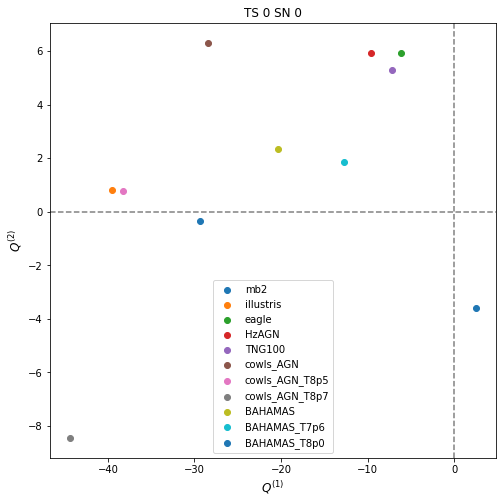

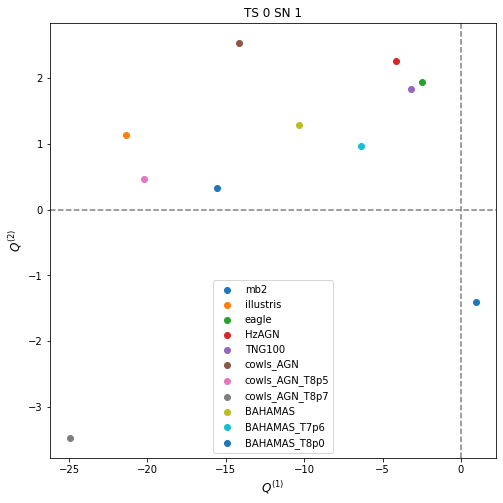

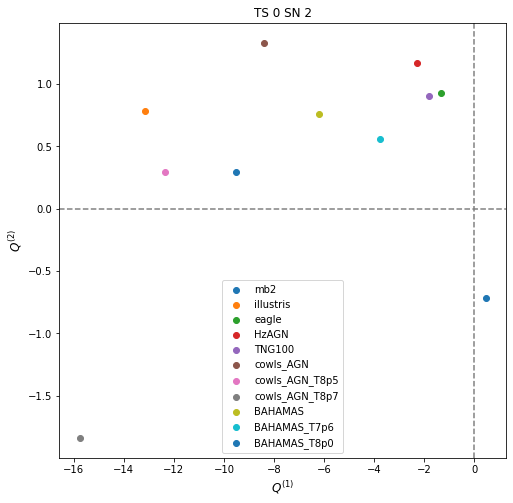

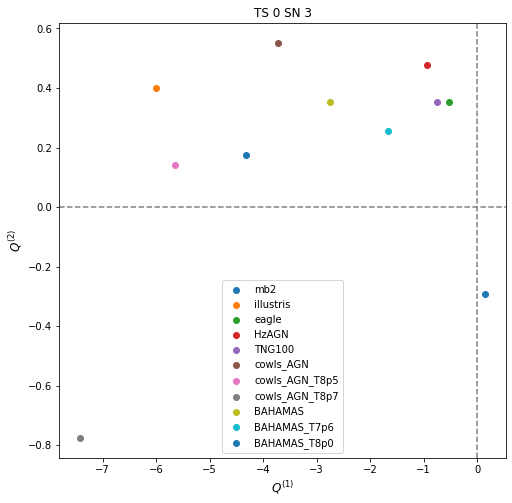

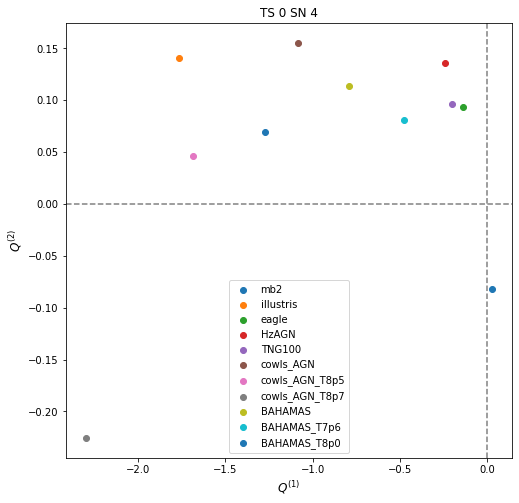

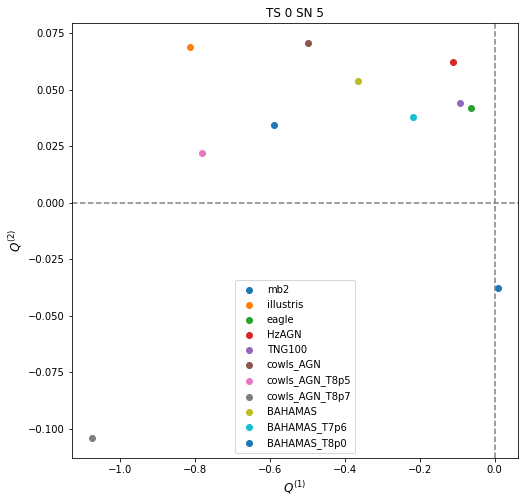

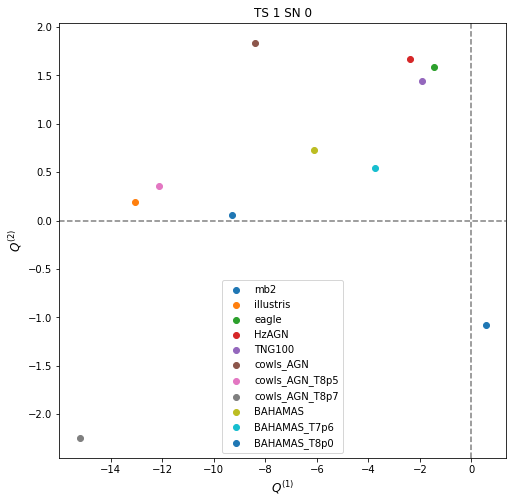

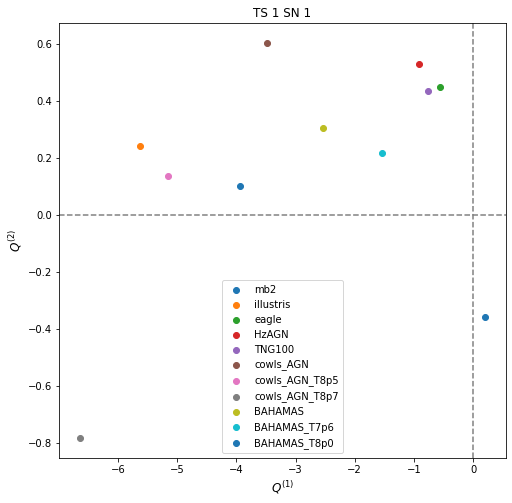

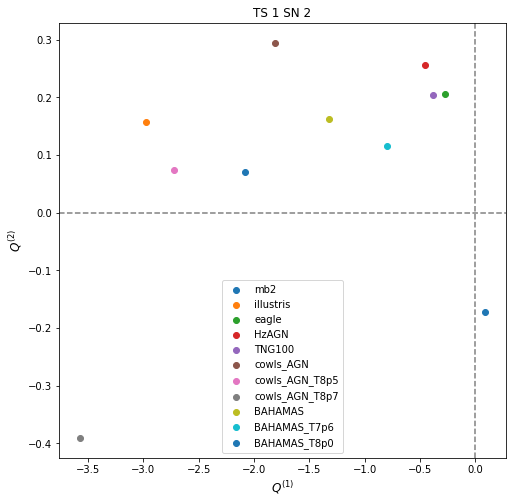

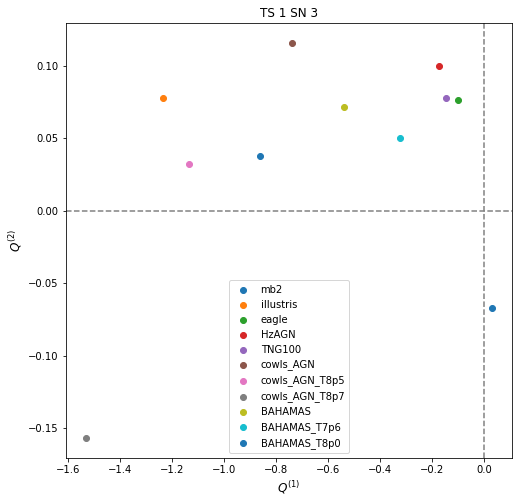

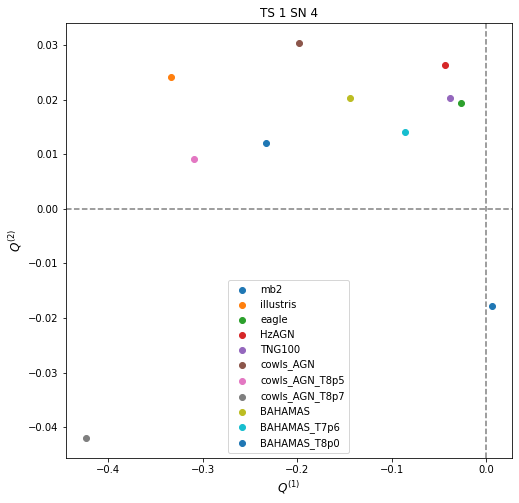

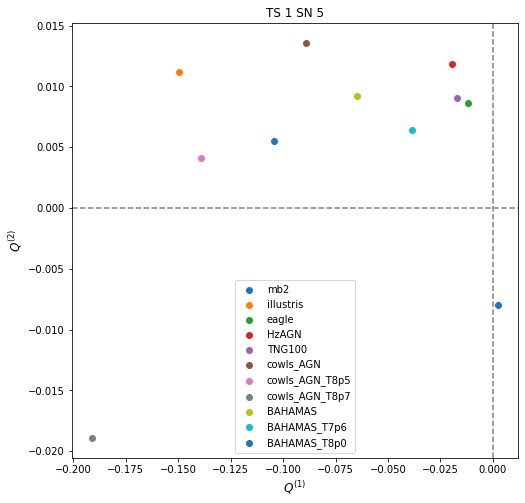

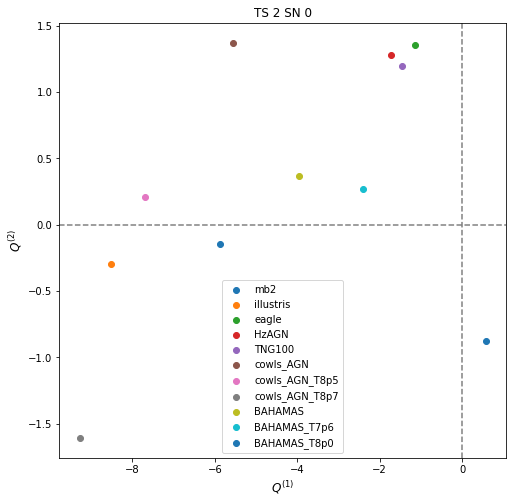

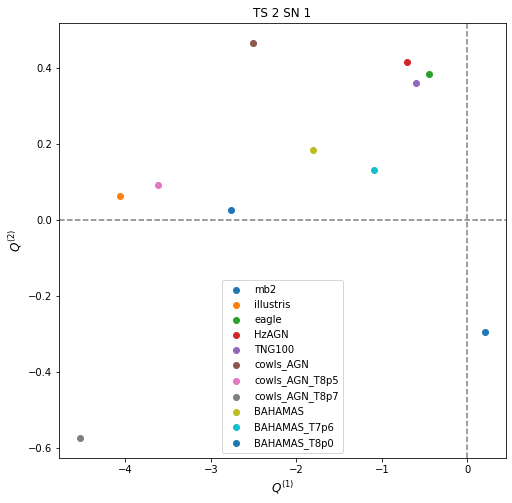

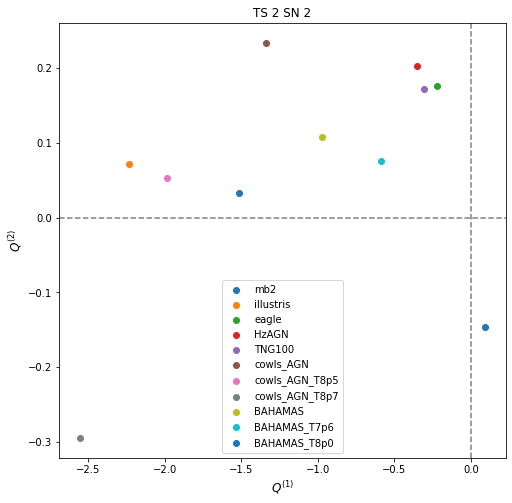

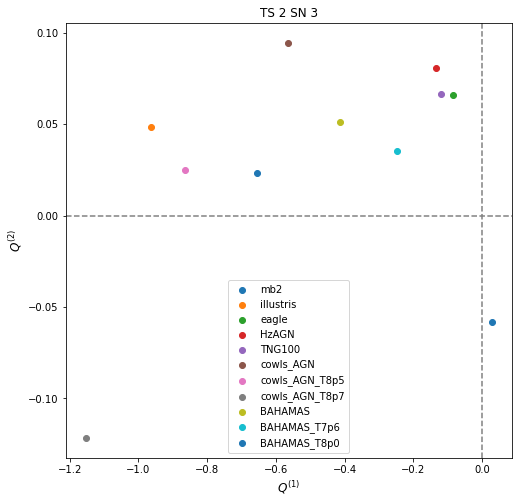

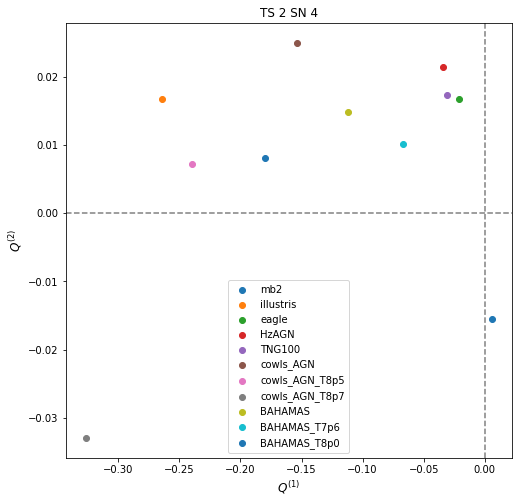

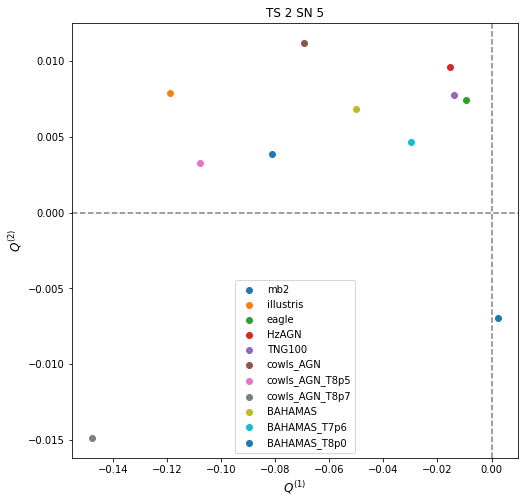

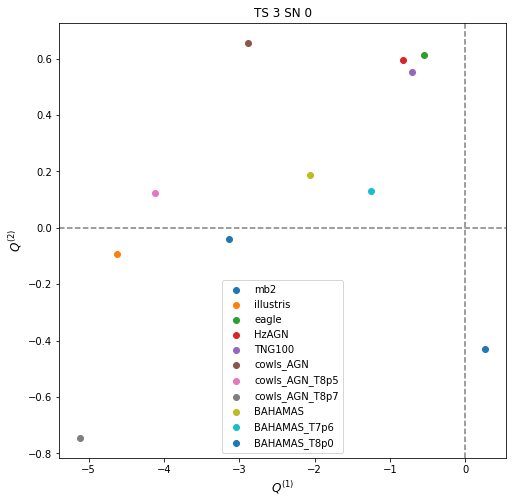

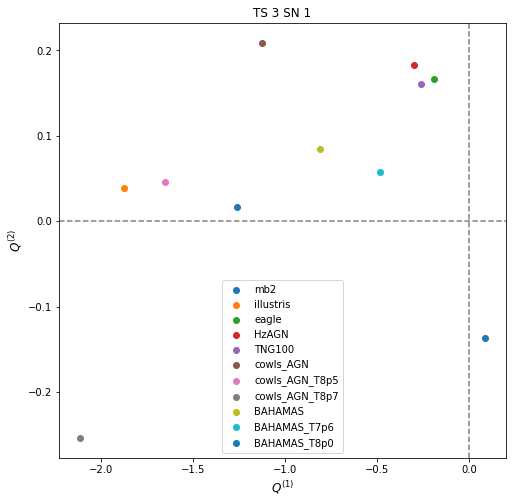

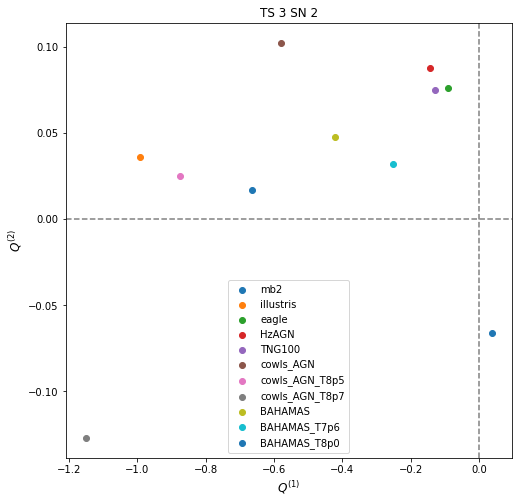

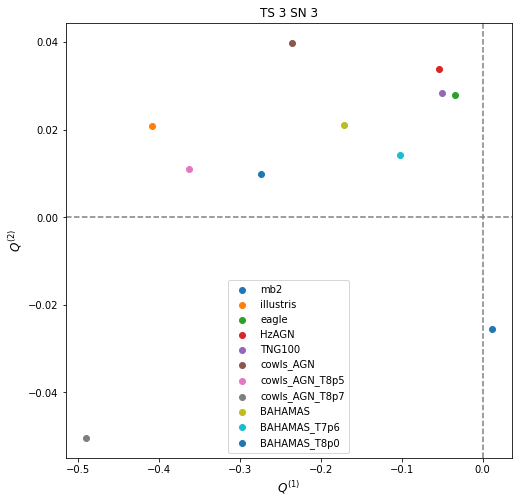

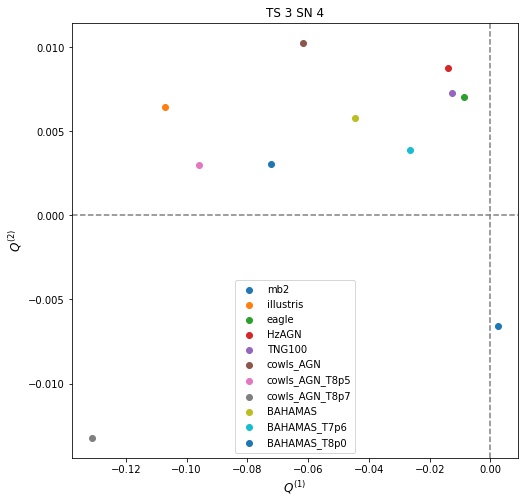

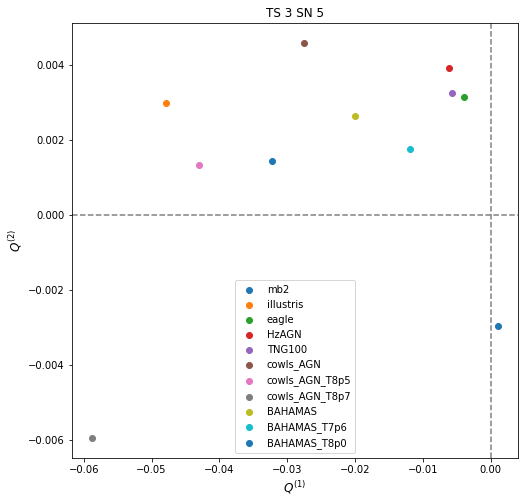

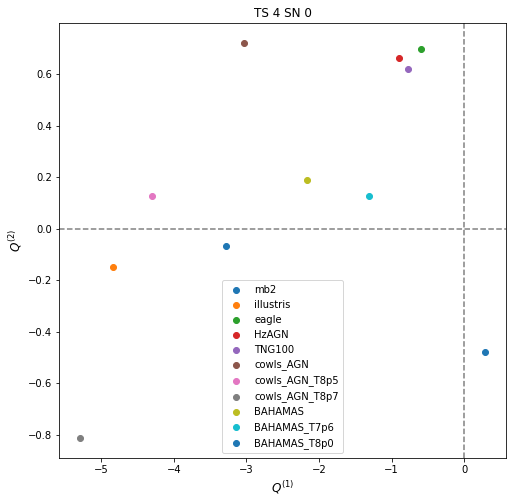

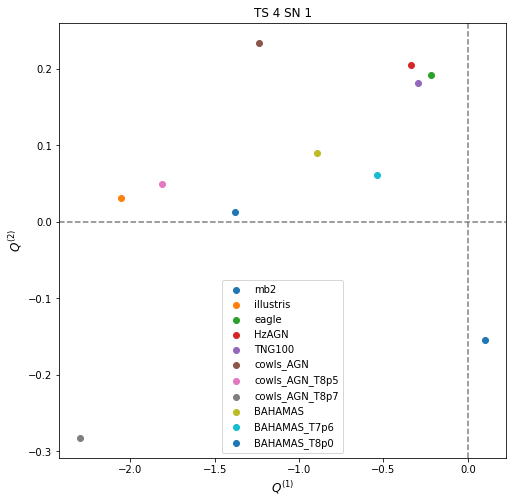

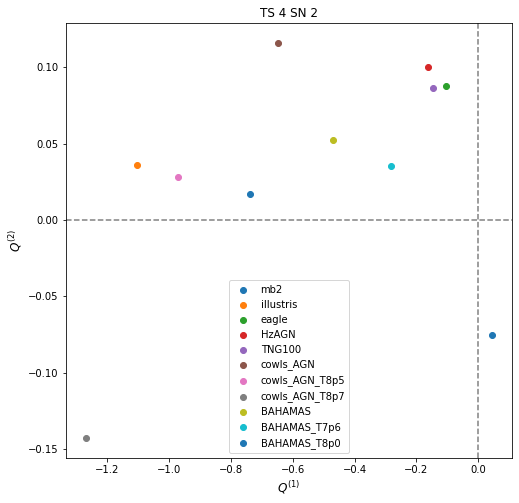

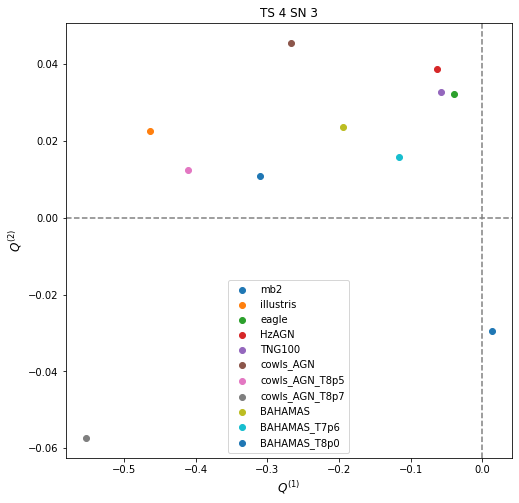

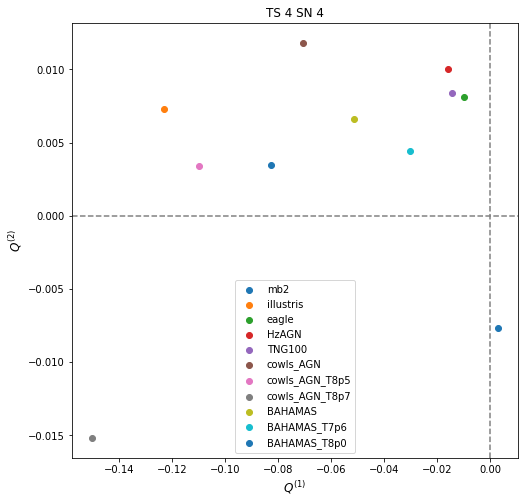

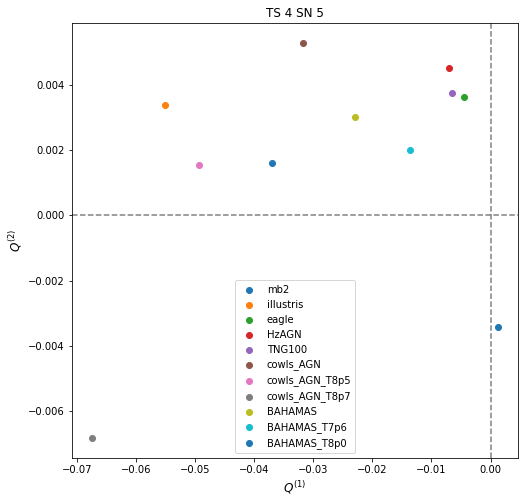

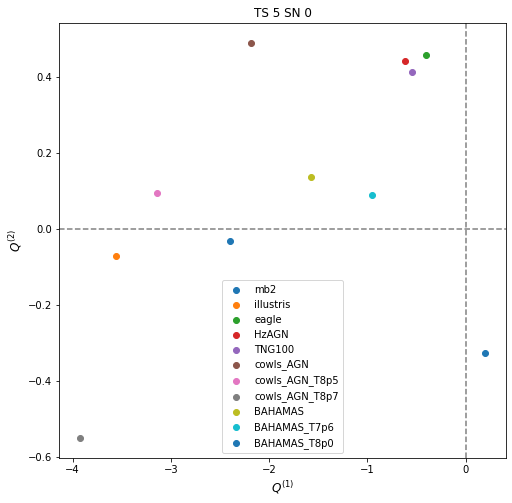

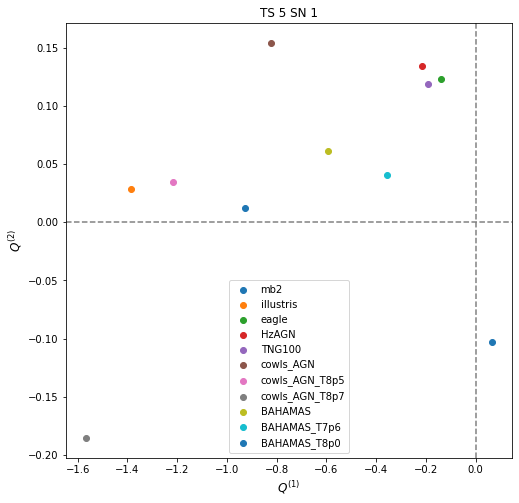

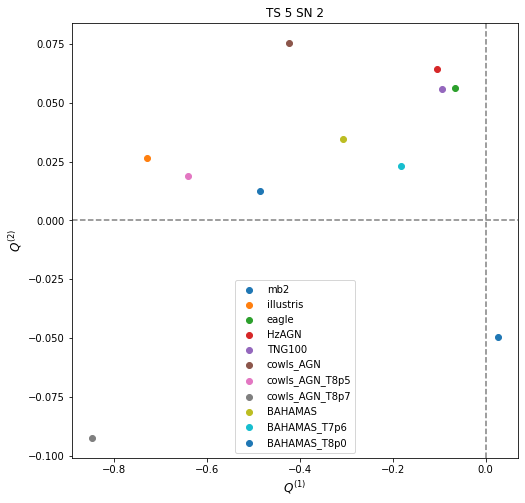

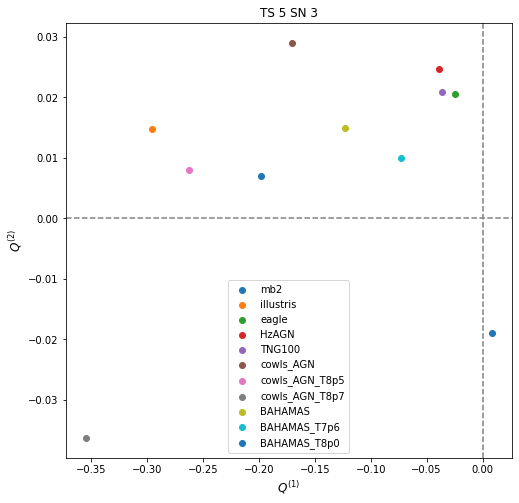

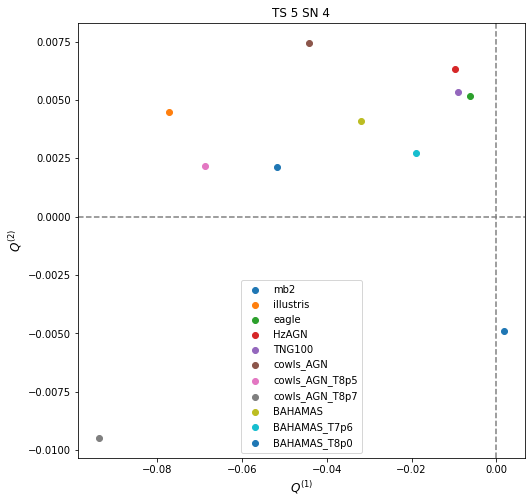

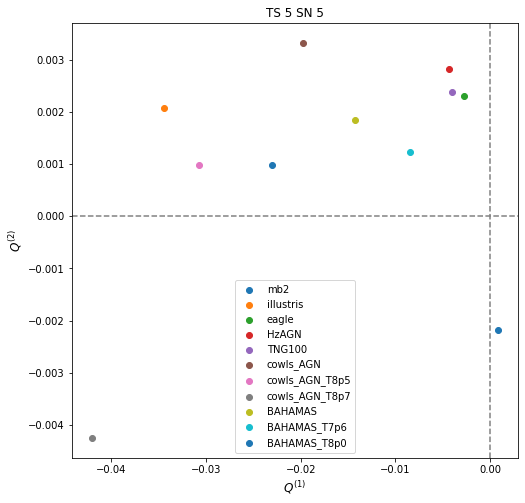

In [6]:
for i in range(6):
    for j in range(6):
        print(f'Target selection {i}; Shape noise {j}')
        fig, ax = plt.subplots(1,1, figsize=[8,8])
        Q1s, Q2s, Q3s = [], [], []
        for k,v in Qs_range_9sim[i*6+j].items():
            ax.scatter(v[0], v[1], label=k)
            Q1s.append(v[0])
            Q2s.append(v[1])
            Q3s.append(v[2])
        print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
        print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
        print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
        ax.set_title("TS %d SN %d"%(i,j))
        ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
        ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
        ax.axvline(0, ls='--', color='grey')
        ax.axhline(0, ls='--', color='grey')
        ax.legend()
        plt.savefig('test_imgs/PCA_Qrange/TS%d_SN%d_9sim.pdf'%(i,j))

Target selection 0; Shape noise 0
Q1 range (-44.303044332000255, 2.532703431176869)
Q2 range (-8.595571341369936, 6.140427046929198)
Q3 range (-2.4201196794334034, 5.4240122551876455)
Target selection 0; Shape noise 1
Q1 range (-24.916482536514742, 0.9602160402330409)
Q2 range (-3.508726181209515, 2.5058723031522576)
Q3 range (-0.9640947874706723, 2.2564687809003976)
Target selection 0; Shape noise 2
Q1 range (-15.759628763808891, 0.463062797957555)
Q2 range (-1.8564344781303923, 1.322924330564466)
Q3 range (-1.2187927313286187, 0.4967908523371252)
Target selection 0; Shape noise 3
Q1 range (-7.4267077157287265, 0.15358393204660295)
Q2 range (-0.7819208782330072, 0.550021765718954)
Q3 range (-0.5097783348523237, 0.19941089398751585)
Target selection 0; Shape noise 4
Q1 range (-2.298166560680091, 0.025867031691165318)
Q2 range (-0.22724479784045004, 0.15530747386630023)
Q3 range (-0.05408736739644736, 0.13996799491949008)
Target selection 0; Shape noise 5
Q1 range (-1.0742203452522694, 

/tmp/ipykernel_30963/1460751883.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=[8,8])


Target selection 3; Shape noise 3
Q1 range (-0.49010909020669685, 0.01120866602128175)
Q2 range (-0.050590944456174, 0.039779590967118465)
Q3 range (-0.01695670720238094, 0.039797881790529566)
Target selection 3; Shape noise 4
Q1 range (-0.13103454769804426, 0.0024855419273732663)
Q2 range (-0.013292925511844248, 0.010269021091964505)
Q3 range (-0.004381859763286261, 0.010564120705627365)
Target selection 3; Shape noise 5
Q1 range (-0.058744338069374895, 0.0010801698629999187)
Q2 range (-0.005964747287146511, 0.004585554676989704)
Q3 range (-0.001959319780016602, 0.004755601164467611)
Target selection 4; Shape noise 0
Q1 range (-5.2962531831655495, 0.29827387298980257)
Q2 range (-0.8184202799236298, 0.7314509299607463)
Q3 range (-0.5701942637752575, 0.2939993498003114)
Target selection 4; Shape noise 1
Q1 range (-2.2988388649193623, 0.10451570939730859)
Q2 range (-0.2836024228613676, 0.2311646276668589)
Q3 range (-0.21866964006009115, 0.10080599278556365)
Target selection 4; Shape nois

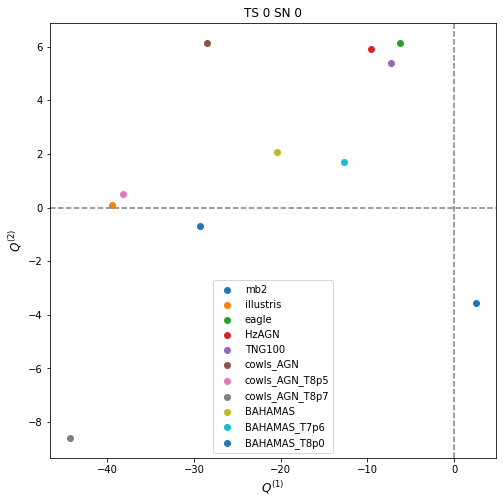

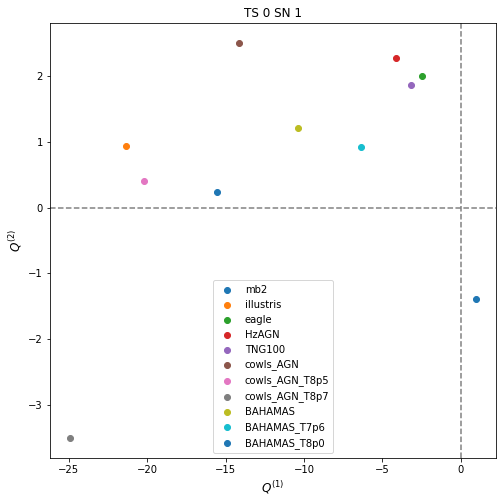

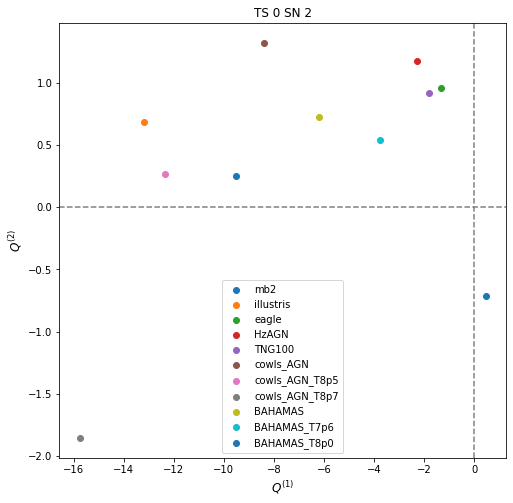

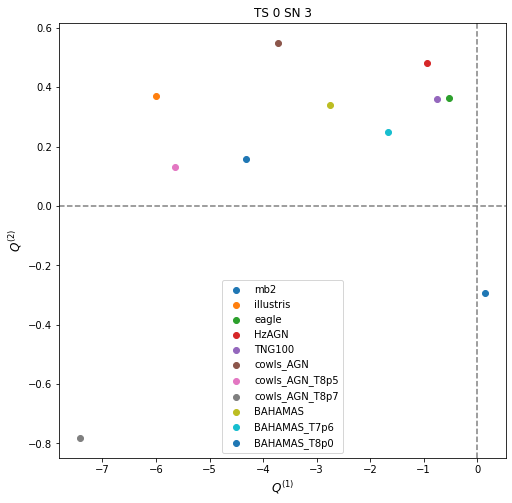

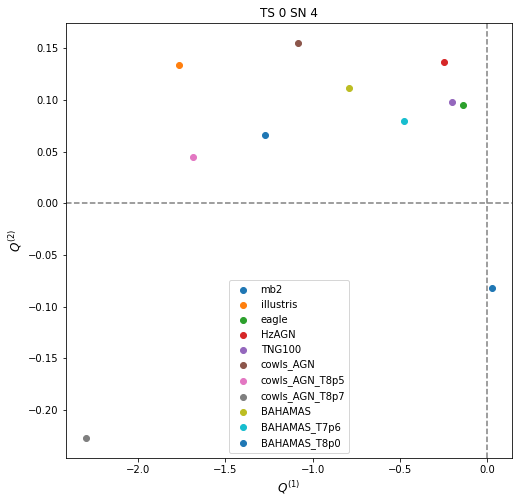

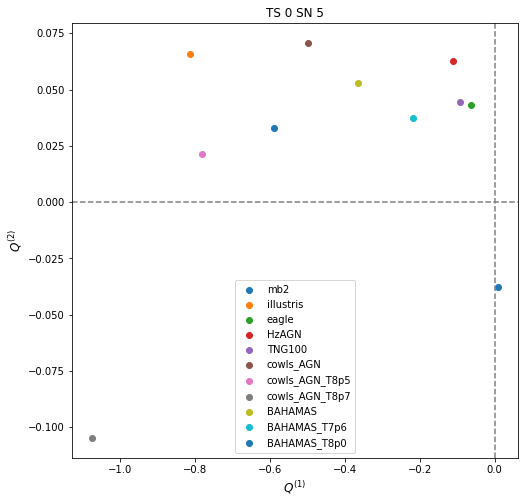

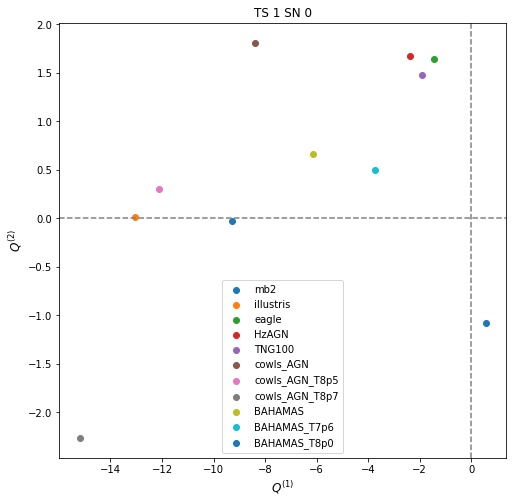

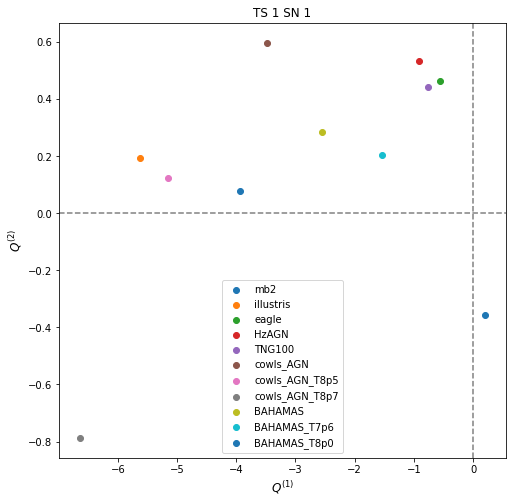

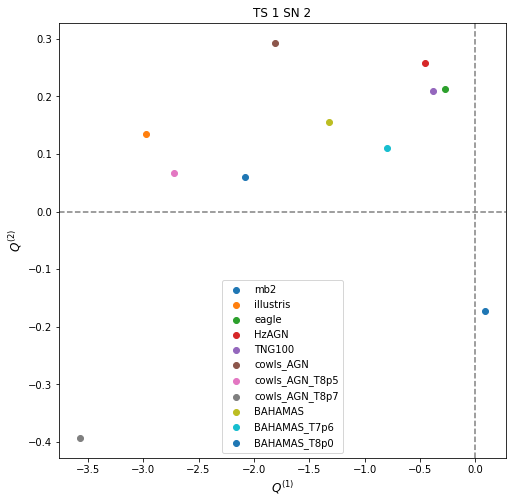

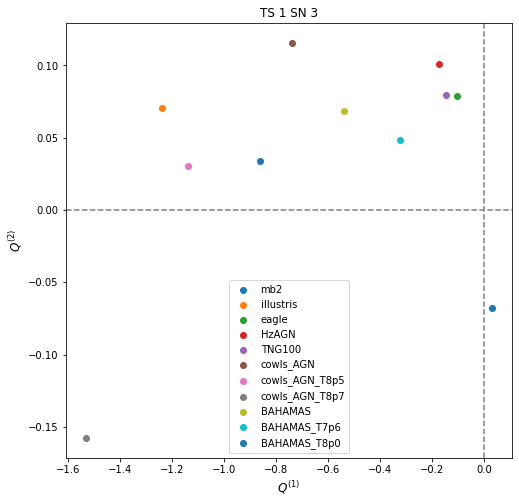

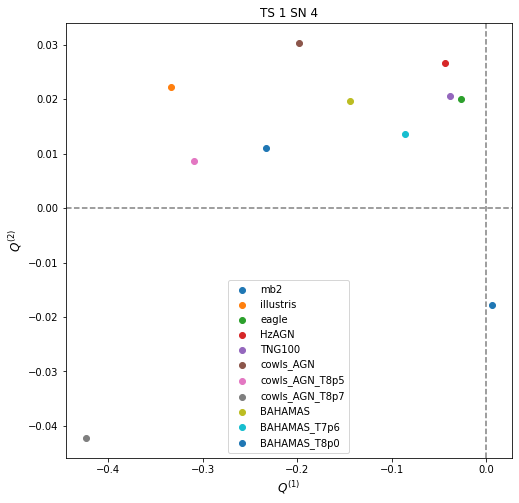

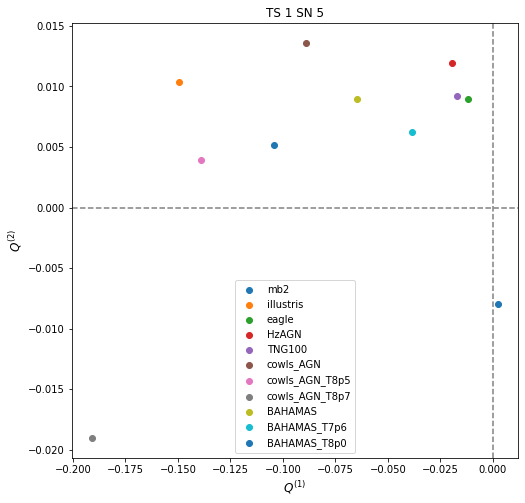

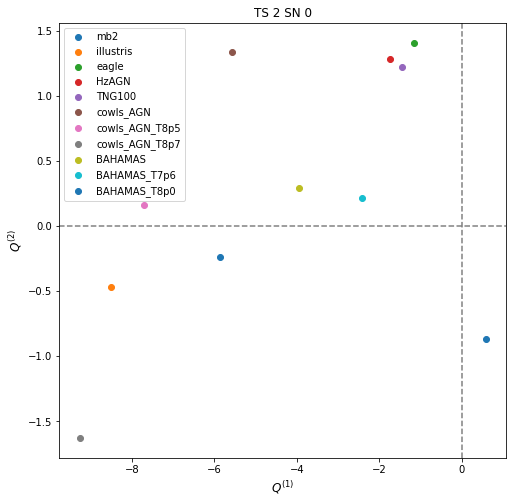

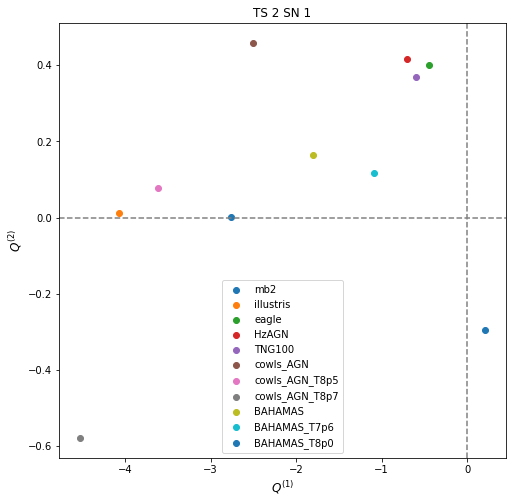

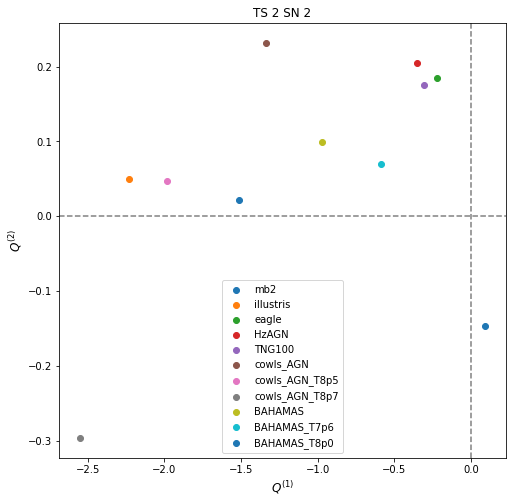

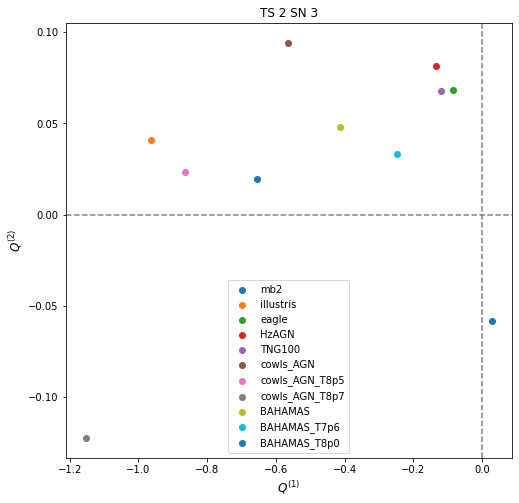

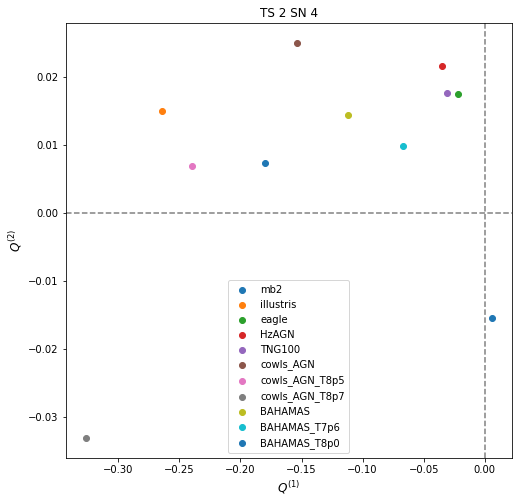

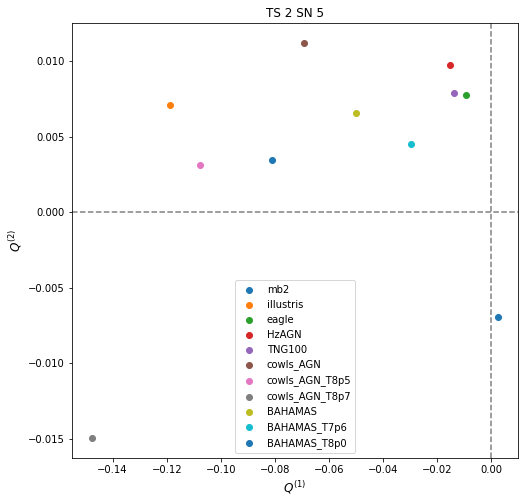

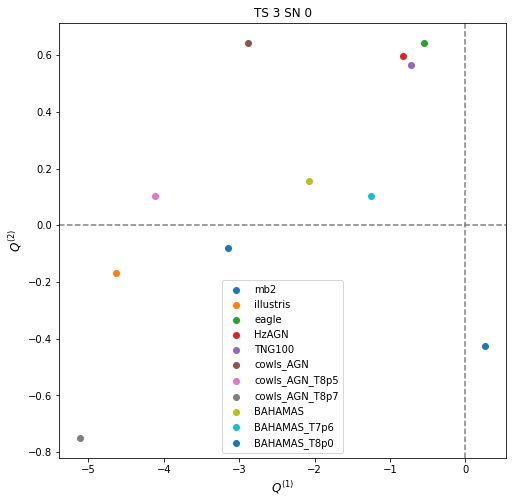

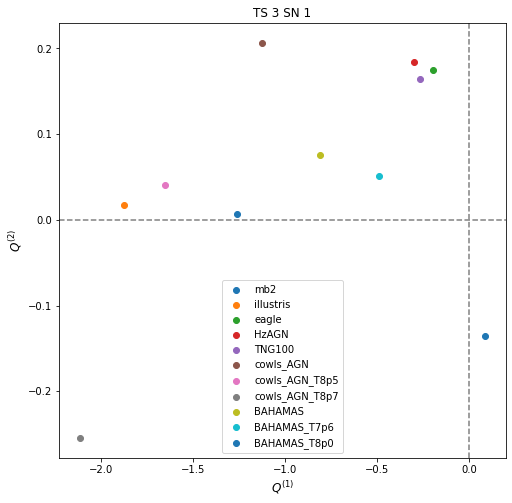

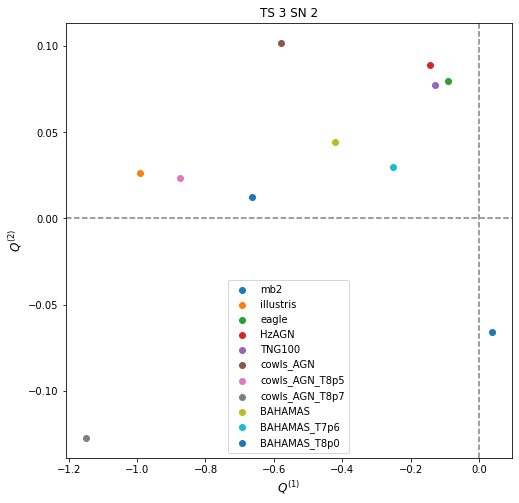

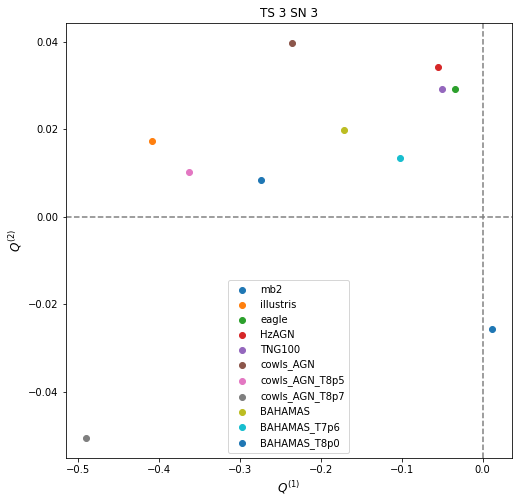

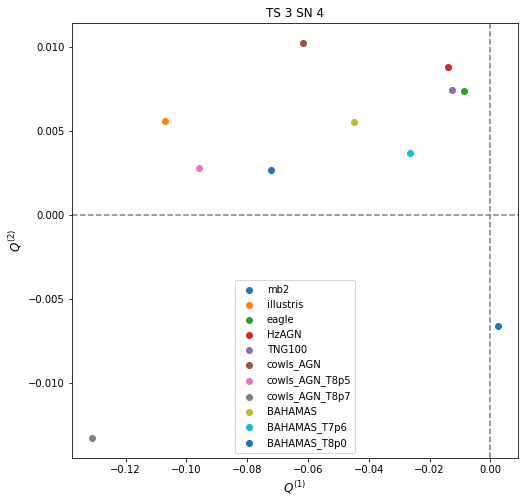

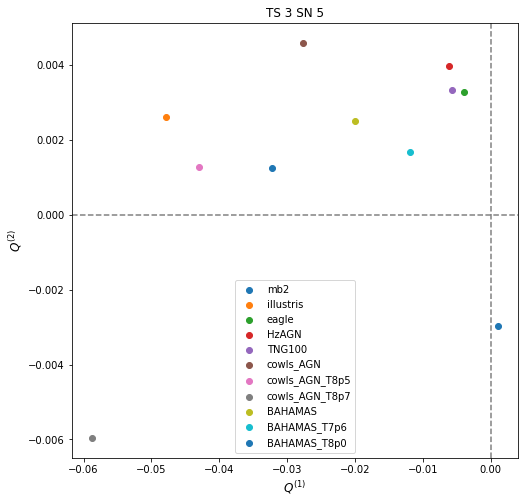

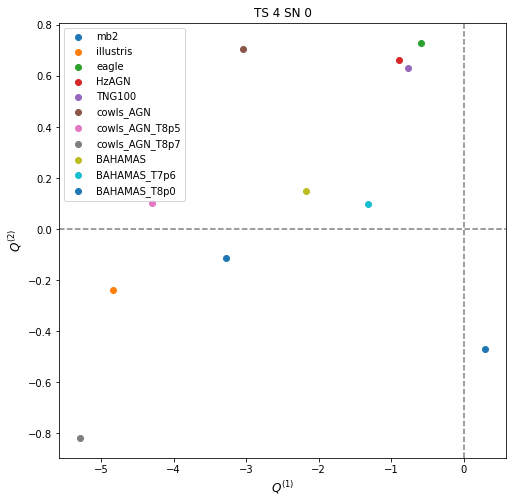

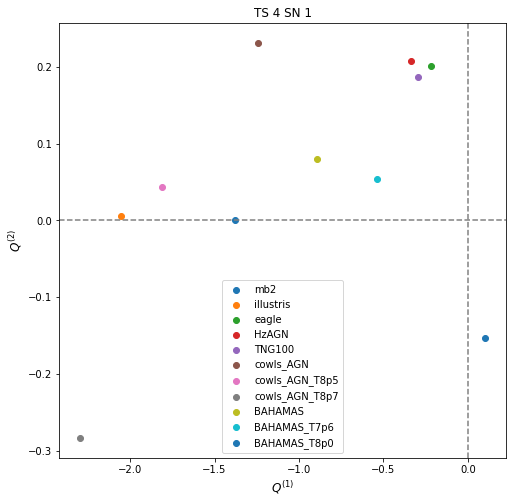

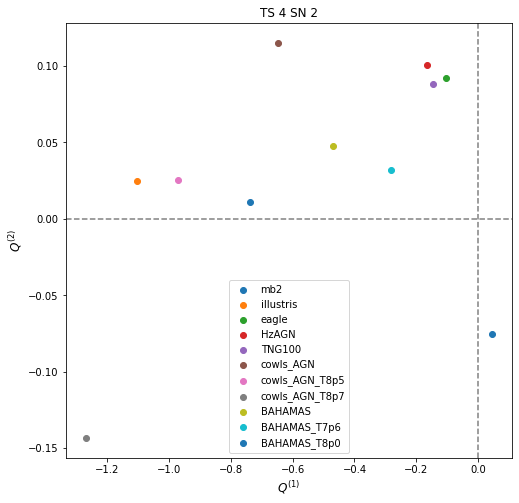

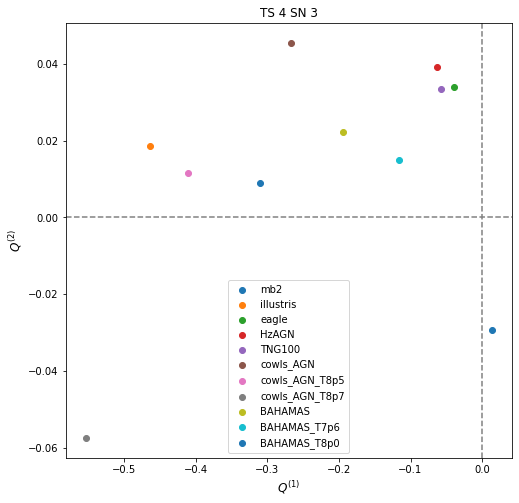

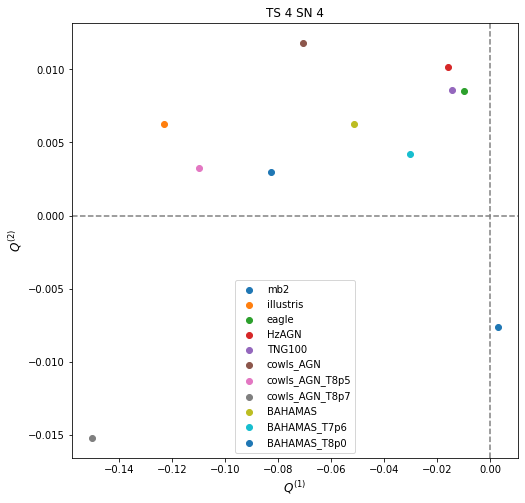

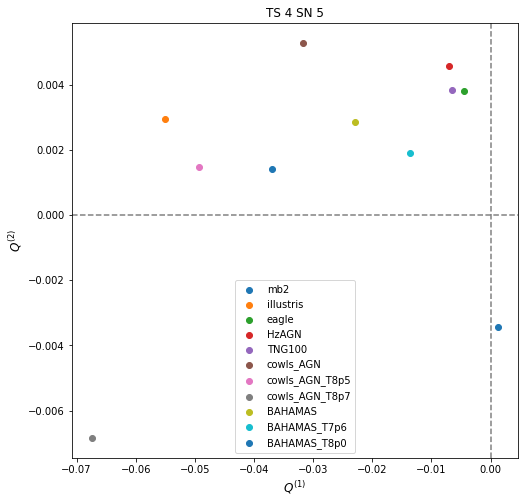

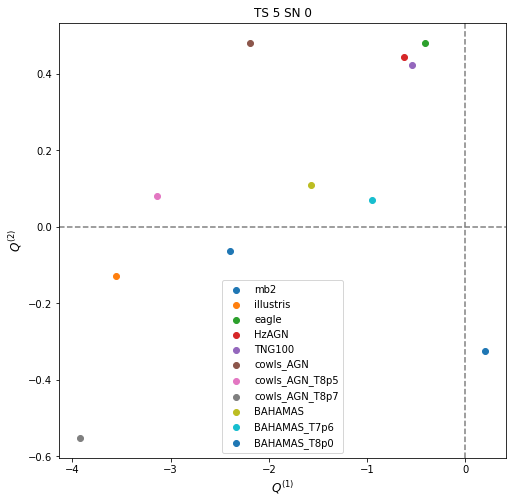

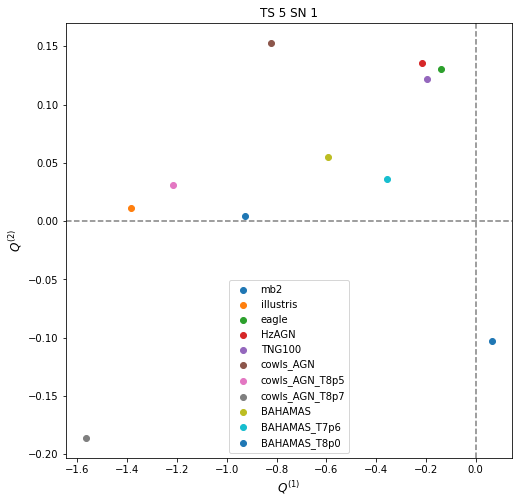

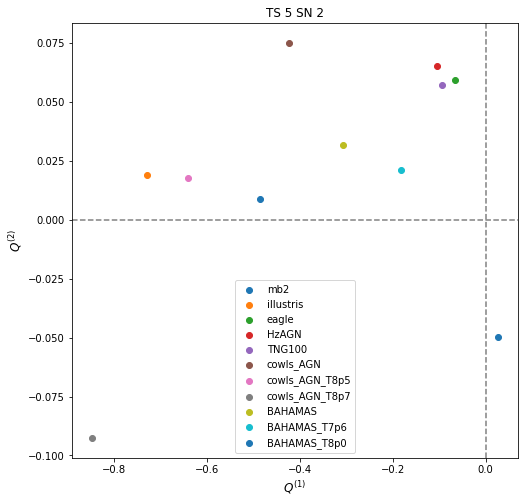

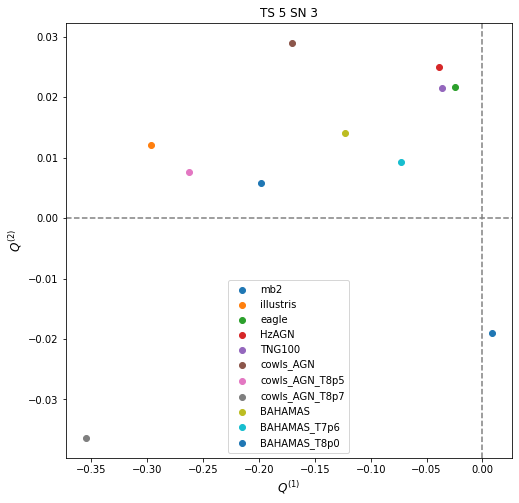

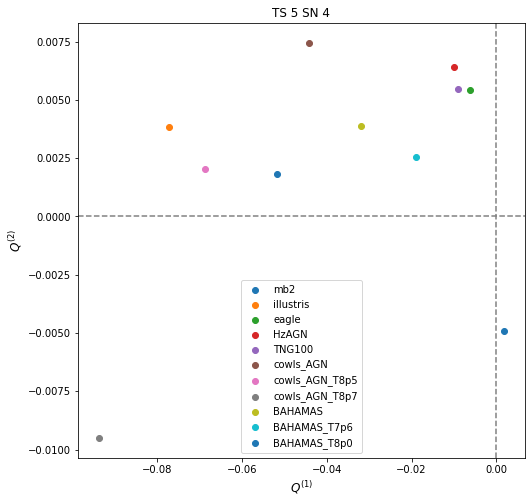

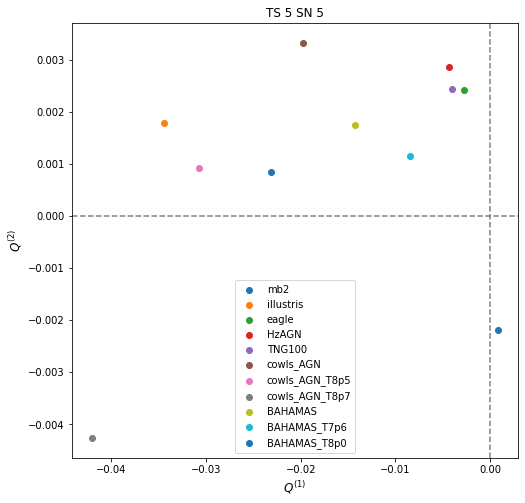

In [7]:
for i in range(6):
    for j in range(6):
        print(f'Target selection {i}; Shape noise {j}')
        fig, ax = plt.subplots(1,1, figsize=[8,8])
        Q1s, Q2s, Q3s = [], [], []
        for k,v in Qs_range_10sim[i*6+j].items():
            ax.scatter(v[0], v[1], label=k)
            Q1s.append(v[0])
            Q2s.append(v[1])
            Q3s.append(v[2])
        print(f'Q1 range ({np.min(Q1s)}, {np.max(Q1s)})')
        print(f'Q2 range ({np.min(Q2s)}, {np.max(Q2s)})')
        print(f'Q3 range ({np.min(Q3s)}, {np.max(Q3s)})')
        ax.set_title("TS %d SN %d"%(i,j))
        ax.set_xlabel(r'$Q^{(1)}$', fontsize=12)
        ax.set_ylabel(r'$Q^{(2)}$', fontsize=12)
        ax.axvline(0, ls='--', color='grey')
        ax.axhline(0, ls='--', color='grey')
        ax.legend()
        plt.savefig('test_imgs/PCA_Qrange/TS%d_SN%d_10sim.pdf'%(i,j))

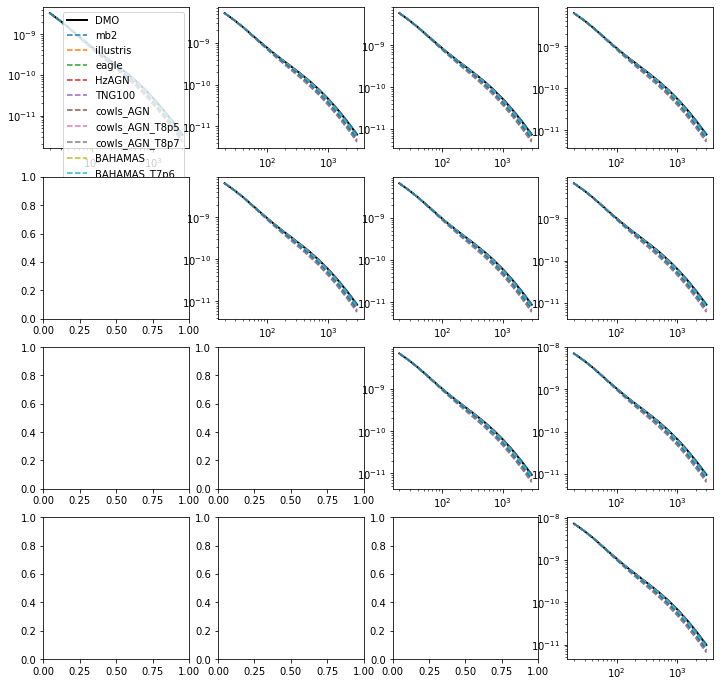

In [20]:
iSelect, iSN = 0, 0

# examine some PCs
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 16]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
# dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
# PCs = np.genfromtxt(PCs_fmt%(iSelect, iSN, 9))
dv_dm = np.genfromtxt(dvfmt+"_dmo")
PCs = np.genfromtxt(PCs_fmt%(9))
dv_bary = []
for bary in bary_scenarios:
#     _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    _dv = np.genfromtxt(dvfmt+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0], 
                        dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0], 
                        label='PC1', color='pink',alpha=1)
        ax.set(xscale='log', yscale='log',)
        ct += 15
axes[0,0].legend()
plt.show()

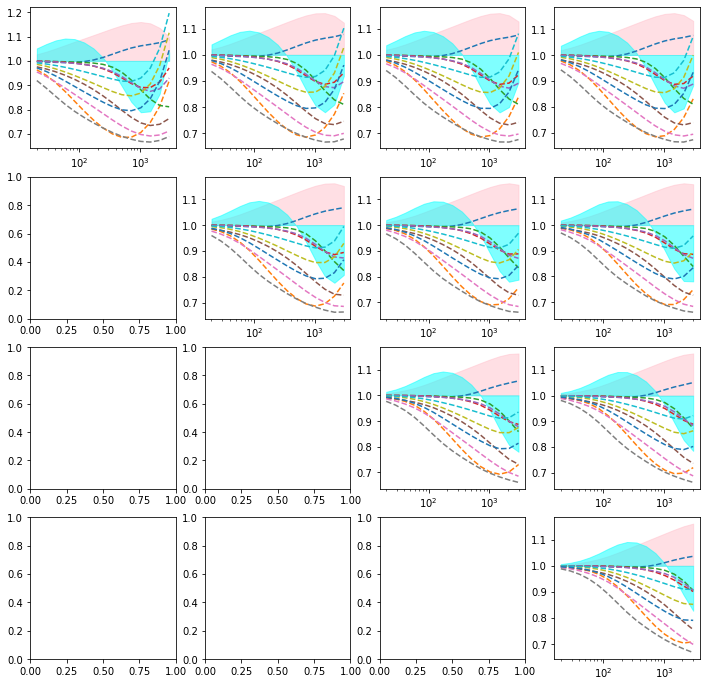

In [10]:
iSelect, iSN = 4,1
# examine some PCs
fig, axes = plt.subplots(4, 4, figsize=(12,12))
Q1 = [0, 1]
Q2 = [0, 1]
Q3 = [0, 1]
ell = np.logspace(np.log10(20), np.log10(3000), 15)
### 
dv_dm = np.genfromtxt(dvfmt%(iSelect,0)+"_dmo")
PCs = np.genfromtxt(PCs_fmt%(iSelect, iSN, 9))
dv_bary = []
for bary in bary_scenarios:
    _dv = np.genfromtxt(dvfmt%(iSelect,0)+"_%s"%bary)
    dv_bary.append(_dv)
ct = 0
for i in range(4):
    for j in range(i,4):
        ax = axes[i,j]
        #ax.plot(ell, dv_dm[ct:ct+15,1], label='DMO', ls='-', color='k', lw=2)
        for dv,bary in zip(dv_bary,bary_scenarios):
            ax.plot(ell, dv[ct:ct+15,1]/dv_dm[ct:ct+15,1], label=bary, ls='--')
        ax.fill_between(ell, 
                        (dv_dm[ct:ct+15,1]+Q1[0]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        (dv_dm[ct:ct+15,1]+Q1[1]*PCs[ct:ct+15,0])/dv_dm[ct:ct+15,1], 
                        label='PC1', color='pink',alpha=0.5)
        ax.fill_between(ell, 
                        (dv_dm[ct:ct+15,1]+Q2[0]*PCs[ct:ct+15,1])/dv_dm[ct:ct+15,1], 
                        (dv_dm[ct:ct+15,1]+Q2[1]*PCs[ct:ct+15,1])/dv_dm[ct:ct+15,1], 
                        label='PC2', color='cyan',alpha=0.5)
#         ax.fill_between(ell, 
#                         (dv_dm[ct:ct+15,1]+Q3[0]*PCs[ct:ct+15,2])/dv_dm[ct:ct+15,1], 
#                         (dv_dm[ct:ct+15,1]+Q3[1]*PCs[ct:ct+15,2])/dv_dm[ct:ct+15,1], 
#                         label='PC3', color='green',alpha=0.5)
        ax.set(xscale='log',)
        ct += 15
plt.show()